## Load State and Action data

In [26]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [27]:
# We load the logged state and scheduling actions from the default scheduler
states = pd.read_csv("../data/states.csv")
actions = pd.read_csv("../data/actions.csv")

# We convert some units
# Some unity conversion

states["node_cpu_total"] = states["node_cpu_total_milli"] / 1000.0
states["pod_cpu_request"] = states["pod_cpu_request_milli"] / 1000.0
states["pod_ram_request_mib"] = states["pod_ram_request_mib"] / (1024.0 * 1024.0)

# Datetime conversion
states["timestamp"] = pandas.to_datetime(states["timestamp"])
actions["timestamp"] = pandas.to_datetime(actions["timestamp"])

In [23]:
actions.head()

,timestamp,pod_name,chosen_node_name
0,2025-05-31 14:54:07.555752709+00:00,workload-6924,cloud-7
1,2025-05-31 14:54:07.671938305+00:00,workload-8868,cloud-6
2,2025-05-31 14:54:07.773946227+00:00,workload-7539,cloud-5
3,2025-05-31 14:54:07.900168788+00:00,workload-4565,cloud-3
4,2025-05-31 14:54:08.025001287+00:00,workload-594,cloud-6


In [24]:
states.head()

,timestamp,pod_name,pod_cpu_request_milli,pod_ram_request_mib,candidate_node_name,node_cpu_total_milli,node_ram_total_mib,node_cpu_model_energy_val,node_type,energy_before,energy_after,node_cpu_total,pod_cpu_request
0,2025-05-31 14:54:07.535977633+00:00,workload-6924,6000,3072.0,cloud-1,8000,16384,169.5159,cloud,225.5013,582.9039,8.0,6.0
1,2025-05-31 14:54:07.536603485+00:00,workload-6924,6000,3072.0,cloud-2,10000,24576,179.1791,cloud,223.5013,546.4454,10.0,6.0
2,2025-05-31 14:54:07.538592719+00:00,workload-6924,6000,3072.0,cloud-6,24000,61440,179.1791,cloud,214.5013,389.1925,24.0,6.0
3,2025-05-31 14:54:07.539086571+00:00,workload-6924,6000,3072.0,cloud-8,8000,40960,166.3510,cloud,200.5013,590.9039,8.0,6.0
4,2025-05-31 14:54:07.540654240+00:00,workload-6924,6000,3072.0,cloud-4,6000,49152,166.3510,cloud,226.5013,729.9514,6.0,6.0


In [ ]:

# Assuming these constants are defined elsewhere or passed in
UNSCHEDULABLE_PENALTY = -1000.0 # Example penalty

def encode_node_type(node_type_str: str) -> float:
    if node_type_str == 'edge':
        return 1.0
    elif node_type_str == 'cloud':
        return 2.0
    else: # unknown or other
        return 0.0
    
def getBonusCoeff(node_type_str: str) -> float:
    if node_type_str == 'edge':
        return 0.6 # Example bonus coefficient for edge nodes
    else:
        return 1.0

# This method builds (s_t, r_t, s_{t+1}, done) tuples
# s_t: features of (pod + chosen_node_before_placement)
# r_t: reward for choosing that node for that pod
# s_{t+1}: features representing the state after the action (simplified for offline)
# done: boolean, true if terminal (e.g., unschedulable)
def build_transitions(state_df: pd.DataFrame, action_df: pd.DataFrame, unschedulable_penalty=UNSCHEDULABLE_PENALTY):
    transitions = []

    # Sort by pod and then by timestamp to process in order
    state_df.sort_values(by=['pod_name', 'timestamp'], inplace=True)
    action_df.sort_values(by=['pod_name', 'timestamp'], inplace=True)

    # --- 1. Process successfully scheduled pods (from action_df) ---
    for _, action_row in action_df.iterrows():
        pod_name = action_row['pod_name']
        chosen_node_name = action_row['chosen_node_name']
        action_timestamp = action_row['timestamp']

        # Find the PRE_DECISION_STATE log entry in state_df that corresponds to
        # this pod being evaluated on the chosen_node_name, immediately *before*
        # or at the action_timestamp.

        # Filter states for the current pod and the chosen node
        candidate_state_entries = state_df[
            (state_df['pod_name'] == pod_name) &
            (state_df['candidate_node_name'] == chosen_node_name)
        ]

        if candidate_state_entries.empty:
            # This might happen if logging is imperfect or action occurs before state log for that node.
            print(f"Warning: No matching state_df entry found for action: Pod {pod_name} on Node {chosen_node_name} at {action_timestamp}. Skipping.")
            continue

        # Get the state entry for the chosen node
        chosen_state_log_entry = candidate_state_entries.iloc[0]

        # Build s_t (current state for the (pod, chosen_node) pair BEFORE placement)
        # Features:
        # 0: pod_cpu_request
        # 1: pod_ram_request_mib
        # 2: candidate_node_cpu_total (of the chosen_node)
        # 3: candidate_node_ram_total_mib (of the chosen_node)
        # 4: candidate_node_cpu_model_energy_val (of the chosen_node)
        # 5: candidate_node_type (encoded) (of the chosen_node)
        # 6: energy_before (LGBM prediction if this pod is placed on this chosen_node)
        s_t = np.array([
            chosen_state_log_entry['pod_cpu_request'],
            chosen_state_log_entry['pod_ram_request_mib'],
            chosen_state_log_entry['node_cpu_total'],
            chosen_state_log_entry['node_ram_total_mib'],
            chosen_state_log_entry['node_cpu_model_energy_val'],
            encode_node_type(chosen_state_log_entry['node_type']),
            chosen_state_log_entry['energy_before']
        ], dtype=np.float32)

        # Reward r_t: Negative of the energy *after* this pod is placed on the chosen node.
        # This 'energy_after' is from the state_df log, which represents the
        # Important: We multiply by a coefficient of 0.9 for edge nodes to encourage their use.
        r_t = -float(chosen_state_log_entry['energy_after']) * getBonusCoeff(chosen_state_log_entry['node_type'])

        # Build s_{t+1} (next state) - Simplified for offline learning
        # This represents the state of the *chosen_node* after the pod has been placed.
        # For a true DQN s', this would be the state for the *next* pod's decision.
        # Here, we use it as the resulting state of the current action on the chosen node.
        # The pod features for s_{t+1} are often zeroed out or set to an average/placeholder
        # if we don't know the next pod.
        s_next = np.array([
            0.0,  # Placeholder for next pod's CPU (unknown in this simplified s_next)
            0.0,  # Placeholder for next pod's RAM
            chosen_state_log_entry['node_cpu_total'], # Node properties are static
            chosen_state_log_entry['node_ram_total_mib'],
            chosen_state_log_entry['node_cpu_model_energy_val'],
            encode_node_type(chosen_state_log_entry['node_type']),
            chosen_state_log_entry['energy_after'] # The energy of this node *after* current pod
        ], dtype=np.float32)

        done = False # Successfully scheduled

        transitions.append((s_t, r_t, s_next, done))

    # --- 2. Process unschedulable pods ---
    all_pods_in_state_log = set(state_df['pod_name'].unique())
    scheduled_pods_in_action_log = set(action_df['pod_name'].unique())
    unschedulable_pod_names = all_pods_in_state_log - scheduled_pods_in_action_log

    for pod_name in unschedulable_pod_names:
        # This pod was evaluated (has entries in state_df) but never got an action_df entry.
        # We need a representative state for this failure.
        # Let's pick the *first* state entry recorded for this pod during its (failed) scheduling attempt.
        # This assumes state_df is sorted by timestamp for each pod.
        pod_state_entries = state_df[state_df['pod_name'] == pod_name].sort_values(by='timestamp_dt')
        
        if pod_state_entries.empty:
            continue # Should not happen if it was in all_pods_in_state_log

        # Consider the group of states logged around the same time for this pod's attempt.
        # This is heuristic. A better approach might use a session/attempt ID.
        # For simplicity, let's take the state of the first node it was evaluated on.
        first_evaluation_entry_for_unsched_pod = pod_state_entries.iloc[0]

        s_t = np.array([
            first_evaluation_entry_for_unsched_pod['pod_cpu_request_milli'],
            first_evaluation_entry_for_unsched_pod['pod_ram_request_mib'],
            first_evaluation_entry_for_unsched_pod['node_cpu_total_milli'],
            first_evaluation_entry_for_unsched_pod['node_ram_total_mib'],
            first_evaluation_entry_for_unsched_pod['node_cpu_model_energy_val'],
            encode_node_type(first_evaluation_entry_for_unsched_pod['node_type']),
            first_evaluation_entry_for_unsched_pod['energy_before']
        ], dtype=np.float32)

        r_t = unschedulable_penalty # Large negative reward

        # s_{t+1} for a terminal state can be a zero vector or any consistent representation
        s_next = np.zeros_like(s_t, dtype=np.float32)
        
        done = True # This scheduling attempt for the pod ended in failure

        transitions.append((s_t, r_t, s_next, done))
        
    return transitions



In [38]:
transitions = build_transitions(states, actions)


print(f"Total transitions built: {len(transitions)}")

Total transitions built: 49


## Build and train DQN

DQN are essentially a feed forward network that takes in states as input and return the Q-values as an output that we will use to make an action: decide on which node to place the current pod.

We will build the simple DQN network with PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import pickle
from sklearn.preprocessing import StandardScaler # For feature scaling


In [81]:
# Define some constants and hyperparameters
BATCH_SIZE = 16
GAMMA = 0.7       # Discount factor
TAU = 0.005       # Target network update rate
LR = 1e-5         # Learning rate
NUM_TRAINING_STEPS = 50000 # Or epochs over data
PRINT_EVERY_N_STEPS = 500
N_OBSERVATIONS = 7 # pod_cpu, pod_ram, node_cpu, node_ram, node_model_energy, node_type, energy_before

## Setting seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [87]:
# --- DQN Model ---
class DQN(nn.Module):
    def __init__(self, n_observations):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1) # Outputs a single Q-value

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


We now implemenet the training loop that will take the transition matrix that we built earlier from the state and the actions log to train the model, we will need to perform some extra pre-processing to fit the data into PyTorch eco-system as below

In [89]:
SCALER_SAVE_PATH = "../models/scaler.pkl"
MODEL_SAVE_PATH = "../models/dqn_model.pth"


state_df = states.copy()
action_df = actions.copy()

transitions = build_transitions(state_df, action_df)

if not transitions:
    print("No transitions were built. Check your log data and preprocessing logic.")
    exit()

print(f"Built {len(transitions)} transitions.")

# 2. Feature Scaling: Quite important for PyTorch training stability
all_states_for_scaling = np.array([t[0] for t in transitions])
scaler = StandardScaler()
scaler.fit(all_states_for_scaling) # Fit on all s_t

# Save the scaler
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Feature scaler saved to {SCALER_SAVE_PATH}")

# Apply scaling to all states in transitions
scaled_transitions = []
for s_t, r_t, s_next, done in transitions:
    s_t_scaled = scaler.transform(s_t.reshape(1, -1))[0] # Reshape for single sample
    s_next_scaled = scaler.transform(s_next.reshape(1, -1))[0] if not done else np.zeros_like(s_t) # Scale s_next if not terminal
    scaled_transitions.append((s_t_scaled, r_t, s_next_scaled, done))

transitions = scaled_transitions # Use scaled transitions for training


Built 49 transitions.
Feature scaler saved to ../models/scaler.pkl


After scaling the transition matrix, we can now proceed to the training loop logic by init the network weights and the optimizer (Adam), we use L1 smooth loss as the criterion.

To train the DQN we take a batch of the state $s_t$, a batch for the reward $r_t$ and a batch for the next state $s_{t+1}$.

In [92]:
# 3. Initialize Networks and Optimizer
policy_net = DQN(N_OBSERVATIONS).to(device)
target_net = DQN(N_OBSERVATIONS).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()

# Initialize lists to track losses and steps for plotting later
losses = []
steps = []

# MIN Loss will help us save model with the best performance
min_loss = float('inf')

# 4. Training Loop
for step in range(NUM_TRAINING_STEPS):
    if len(transitions) < BATCH_SIZE:
        batch_samples = random.sample(transitions, len(transitions)) if len(transitions) > 0 else []
    else:
        batch_samples = random.sample(transitions, BATCH_SIZE)

    if not batch_samples:
        # print(f"Step {step+1}/{NUM_TRAINING_STEPS}: No samples in batch. Skipping.")
        continue

    states_b = np.array([s[0] for s in batch_samples])
    rewards_b = np.array([s[1] for s in batch_samples])
    next_states_b = np.array([s[2] for s in batch_samples])
    dones_b = np.array([s[3] for s in batch_samples])

    s_tens = torch.tensor(states_b, device=device, dtype=torch.float32)
    r_tens = torch.tensor(rewards_b, device=device, dtype=torch.float32).unsqueeze(1)
    s_next_tens = torch.tensor(next_states_b, device=device, dtype=torch.float32)
    d_tens = torch.tensor(dones_b, device=device, dtype=torch.float32).unsqueeze(1)

    curr_q = policy_net(s_tens)

    next_q_target_net = torch.zeros(len(batch_samples), 1, device=device)
    non_final_mask = (d_tens == 0).squeeze()

    if non_final_mask.any().item(): # Check if any non_final states exist
        non_final_s_next = s_next_tens[non_final_mask]
        if non_final_s_next.numel() > 0: # Check if tensor is not empty
            with torch.no_grad():
                next_q_target_net[non_final_mask] = target_net(non_final_s_next)
    
    expected_q = r_tens + (GAMMA * next_q_target_net * (1.0 - d_tens))
    loss = criterion(curr_q, expected_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Soft update target network
    target_sd = target_net.state_dict()
    policy_sd = policy_net.state_dict()
    for key in policy_sd:
        target_sd[key] = policy_sd[key]*TAU + target_sd[key]*(1-TAU)
    target_net.load_state_dict(target_sd)

    if (step + 1) % PRINT_EVERY_N_STEPS == 0:
        losses.append(loss.item())
        steps.append(step + 1)
        print(f"Step: {step+1}/{NUM_TRAINING_STEPS}, Loss: {loss.item():.4f}")
        if loss.item() < min_loss:
            min_loss = loss.item()
            # Save the model with the best performance
            torch.save(policy_net.state_dict(), MODEL_SAVE_PATH)
            print(f"New best model saved at step {step + 1} with loss {min_loss:.4f}")

KeyboardInterrupt: 

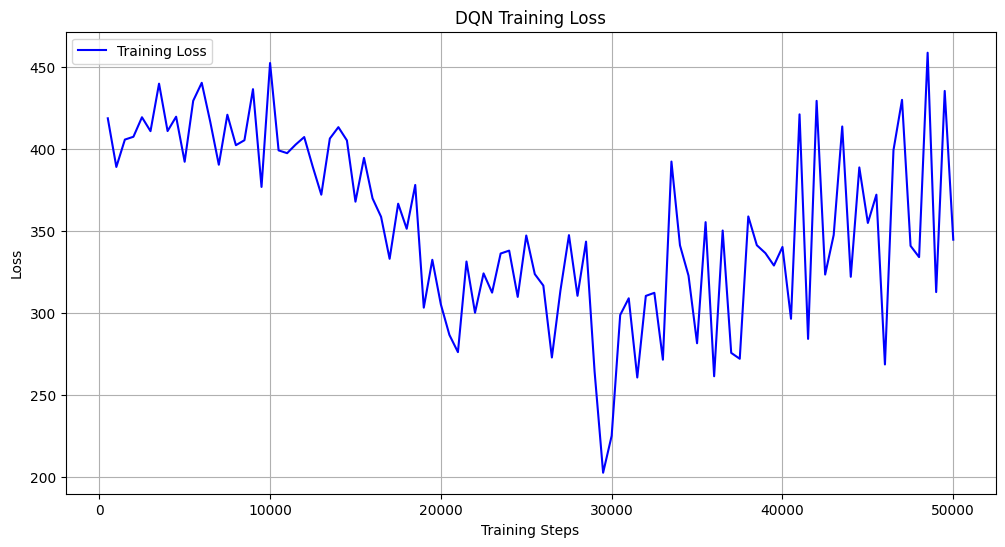

In [91]:
# Plot the training loss over steps
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(steps, losses, label='Training Loss', color='blue')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('DQN Training Loss')
plt.legend()
plt.grid()
plt.savefig("../img/dqn_training_loss.png")

## Inference and test

In [93]:
# --- 7. Inference/Testing Section ---
print("\n--- Inference/Testing Phase ---")

test_set = build_transitions(state_df, action_df)
try:
    # Load the best model for inference
    inference_model = DQN(N_OBSERVATIONS).to(device)
    inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    inference_model.eval() # Set to evaluation mode

    # Load the scaler used during training
    with open(SCALER_SAVE_PATH, 'rb') as f:
        loaded_scaler = pickle.load(f)
    print(f"Loaded scaler from {SCALER_SAVE_PATH}")

    # Test on a few samples from the original (unscaled) raw_transitions
    # Or you could load a separate test dataset if you have one
    num_test_samples = min(10, len(test_set))
    if num_test_samples == 0:
        print("No raw transitions available to test.")
    else:
        print(f"\nPredicting Q-values for {num_test_samples} sample states:")
        # Select some diverse samples if possible, or just the first few
        test_samples_raw = test_set[:num_test_samples]

        for i, (s_t_raw, r_t_raw, s_next_raw, done_raw, chosen_node_raw, pod_name_raw) in enumerate(test_samples_raw):
            # Scale the raw state s_t_raw just like during training
            s_t_scaled_for_test = loaded_scaler.transform(s_t_raw.reshape(1, -1))[0]
            state_tensor = torch.tensor(s_t_scaled_for_test, device=device, dtype=torch.float32).unsqueeze(0) # Add batch dim

            with torch.no_grad():
                predicted_q_value = inference_model(state_tensor).item()
            
            print(f"\nSample {i+1}: Pod '{pod_name_raw}', (Original) Chosen Node '{chosen_node_raw}'")
            print(f"  Raw State (s_t): {np.round(s_t_raw, 2)}")
            print(f"  Scaled State (s_t): {np.round(s_t_scaled_for_test, 2)}")
            print(f"  Predicted Q-value (Score): {predicted_q_value:.4f}")
            print(f"  Actual Reward from log (r_t): {r_t_raw:.4f}")
            if done_raw:
                print("  This was an UNSCHEDULABLE event (terminal state).")
            
            # You could also calculate the expected Q-value using the raw_reward and raw_next_state
            # to see how close the prediction is, but this requires also predicting Q for s_next_raw.
            if not done_raw:
                s_next_scaled_for_test = loaded_scaler.transform(s_next_raw.reshape(1, -1))[0]
                next_state_tensor = torch.tensor(s_next_scaled_for_test, device=device, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    predicted_next_q_value_target = target_net(next_state_tensor).item() # Use target_net for V(s')
                empirical_target_q = r_t_raw + GAMMA * predicted_next_q_value_target
                print(f"  Empirical Target Q (r + gamma*V_target(s')): {empirical_target_q:.4f} (using loaded target_net for V(s'))")


except FileNotFoundError:
    print(f"Error: Could not load model '{MODEL_SAVE_PATH}' or scaler '{SCALER_SAVE_PATH}' for testing.")
except Exception as e:
    print(f"An error occurred during the inference/testing phase: {e}")


--- Inference/Testing Phase ---
Loaded scaler from ../models/scaler.pkl

Predicting Q-values for 10 sample states:
An error occurred during the inference/testing phase: not enough values to unpack (expected 6, got 4)
